In [16]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
import time
from datetime import datetime
from sklearn.preprocessing import StandardScaler

### Вспомогательные функции

In [69]:
# формирование 'мешка слов' для героев
def heroes_bag(data, n):
    # N — количество различных героев в выборке
    X_pick = np.zeros((data.shape[0], n))

    for i, match_id in enumerate(data.index):
        for p in range(5):
            X_pick[i, data.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
            X_pick[i, data.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
            
    return pd.DataFrame(X_pick, index=data.index)

# отрисовка результатов
def plot_scores(с, scores):
    plt.plot(с, scores)
    plt.xlabel('log(C)')
    plt.ylabel('score')
    plt.show()

# подбор оптимального параметра регуляризации
def test_model(X, y):
    scores = []
    с_power = range(-6, 7)
    c_range = [10.0 ** i for i in с_power]
    for c in c_range:
        
        print('c = %s' % c)
        
        # засекаем время
        start_time = datetime.now()    
        model = LogisticRegression(C=c, random_state=42, n_jobs=-1)     
        mean_cv_score = np.mean(cross_val_score(model, X, y, cv=kf, scoring='roc_auc', n_jobs=-1))
        
        print('Time elapsed:', datetime.now() - start_time)
        scores.append(mean_cv_score)

    plot_scores(с_power, scores)
    
    max_score = max(scores)
    max_score_index = scores.index(max_score)
    
    return c_range[max_score_index], max_score

# формирование обучающей выборки (удаление данных итога матча)
def get_sample(X):
    X = X.drop(['duration', 
                        'tower_status_radiant', 
                         'tower_status_dire', 
                         'barracks_status_radiant', 
                         'barracks_status_dire'
                        ], axis=1)
    if target in X.columns:
        X.drop([target], axis=1, inplace=True)
    return X

### Загружаем данные

In [65]:
df_train = pd.read_csv('data/features.csv', index_col='match_id')
df_test = pd.read_csv('data/features_test.csv', index_col='match_id')
heroes = pd.read_csv('data/data/dictionaries/heroes.csv')
n_heroes = len(heroes)
print('Количество героев в игре: %s' % n_heroes)

Количество героев в игре: 112


In [62]:
print(df_train.head(15))

          start_time  lobby_type  r1_hero  r1_level  r1_xp  r1_gold  r1_lh  \
match_id                                                                     
0         1430198770           7       11         5   2098     1489     20   
1         1430220345           0       42         4   1188     1033      9   
2         1430227081           7       33         4   1319     1270     22   
3         1430263531           1       29         4   1779     1056     14   
4         1430282290           7       13         4   1431     1090      8   
5         1430284186           1       11         5   1961     1461     19   
8         1430293701           1        8         3    967     1136      7   
9         1430299335           7       35         5   2117     1252     16   
11        1430308974           1       17         5   1527      906     10   
12        1430316105           7       15         5   1651     1060     14   
14        1430325079           1       22         5   1988     1

### Подготовка данных

In [66]:
target = 'radiant_win'
y_train = df_train[target]
X_train = get_sample(df_train)

# Заполняем пропуски
X_train.fillna(0, inplace=True)

# Масштабирование признаков
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Генератор разбиений для кросс-валидации
kf = KFold(len(X_train), n_folds=5, shuffle=True, random_state=42)

### Обучение на полной выборке

c = 1e-06
Time elapsed: 0:00:03.772881
c = 1e-05
Time elapsed: 0:00:03.976077
c = 0.0001
Time elapsed: 0:00:04.263106
c = 0.001
Time elapsed: 0:00:05.701898
c = 0.01
Time elapsed: 0:00:06.648631
c = 0.1
Time elapsed: 0:00:06.758268
c = 1.0
Time elapsed: 0:00:06.786919
c = 10.0
Time elapsed: 0:00:06.963347
c = 100.0
Time elapsed: 0:00:06.850265
c = 1000.0
Time elapsed: 0:00:07.190356
c = 10000.0
Time elapsed: 0:00:07.101759
c = 100000.0
Time elapsed: 0:00:07.488207
c = 1000000.0
Time elapsed: 0:00:07.099585


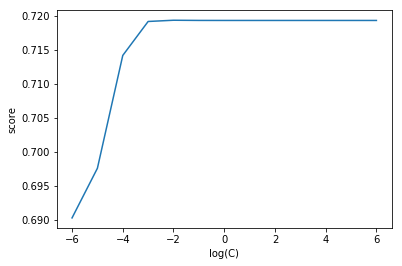

In [67]:
c, best_score = test_model(X_train, y_train)

In [68]:
c, best_score
# (0.01, 0.7165502697259141)

(0.01, 0.7193451519524702)

Наилучшее значение AUC-ROC = 0.719 при C = 0.01.
Это примерно соответствует результату градиентного бустинга с 250 деревьями (логистическая регрессия обучается быстрее).

### Обучение на выборке без категориальных признаков

c = 1e-06
Time elapsed: 0:00:03.617510
c = 1e-05
Time elapsed: 0:00:03.982632
c = 0.0001
Time elapsed: 0:00:04.362285
c = 0.001
Time elapsed: 0:00:05.169338
c = 0.01
Time elapsed: 0:00:05.868168
c = 0.1
Time elapsed: 0:00:06.451066
c = 1.0
Time elapsed: 0:00:06.457703
c = 10.0
Time elapsed: 0:00:06.243442
c = 100.0
Time elapsed: 0:00:06.498312
c = 1000.0
Time elapsed: 0:00:06.344801
c = 10000.0
Time elapsed: 0:00:06.243449
c = 100000.0
Time elapsed: 0:00:06.465462
c = 1000000.0
Time elapsed: 0:00:06.539925


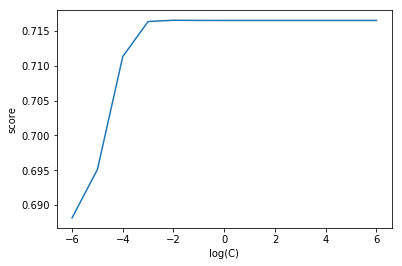

In [25]:
X_train = get_sample(df_train)

cat_features = ['lobby_type'] + ['r{}_hero'.format(n) for n in range(1, 6)] + ['d{}_hero'.format(n) for n in range(1, 6)]
X_train.drop(cat_features, axis=1, inplace=True)
X_train.fillna(0, inplace=True)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

c, best_score = test_model(X_train, y_train)

In [26]:
c, best_score

(0.01, 0.7165593885630225)

Удаление категориальных признаков почти не повлияло на качество предсказания,
модель смогла распознать этот шум.

### Обучение на выборке с 'мешком слов' для героев

c:\python35\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


c = 1e-06
Time elapsed: 0:00:04.376553
c = 1e-05
Time elapsed: 0:00:04.665070
c = 0.0001
Time elapsed: 0:00:05.450395
c = 0.001
Time elapsed: 0:00:08.121023
c = 0.01
Time elapsed: 0:00:09.882187
c = 0.1
Time elapsed: 0:00:10.268669
c = 1.0
Time elapsed: 0:00:10.287148
c = 10.0
Time elapsed: 0:00:10.409815
c = 100.0
Time elapsed: 0:00:10.204673
c = 1000.0
Time elapsed: 0:00:10.502704
c = 10000.0
Time elapsed: 0:00:10.578620
c = 100000.0
Time elapsed: 0:00:10.063918
c = 1000000.0
Time elapsed: 0:00:10.161909


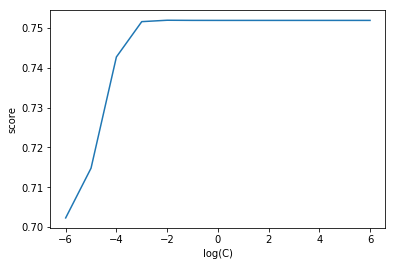

In [49]:
X_train = get_sample(df_train)
X_test = df_test.copy()

cat_features = ['lobby_type'] + ['r{}_hero'.format(n) for n in range(1, 6)] + ['d{}_hero'.format(n) for n in range(1, 6)]
X_train_hero = heroes_bag(X_train, n_heroes)
X_test_hero = heroes_bag(X_test, n_heroes)

X_train.drop(cat_features, axis=1, inplace=True)
X_test.drop(cat_features, axis=1, inplace=True)

X_train_final = pd.concat([X_train, X_train_hero], axis=1)
X_train_final.fillna(0, inplace=True)

X_test_final = pd.concat([X_train, X_test_hero], axis=1)
X_test_final.fillna(0, inplace=True)

scaler = StandardScaler()
X_train_final = scaler.fit_transform(X_train_final)
X_test_final = scaler.transform(X_test_final)

c, best_score = test_model(X_train_final, y_train)

In [50]:
c, best_score

(0.01, 0.7519640431617559)

При добавлении 'мешка слов' по героям качество заметно улучшилось, и теперь AUC-ROC = 0.75 при C = 0.01.

### Применение наилучшей модели к тестовой выборке

In [59]:
model = LogisticRegression(C=0.01, random_state=42, n_jobs=-1)
model.fit(X_train_final, y_train)

y_test = model.predict_proba(X_test_final)[:, 1]
result = pd.DataFrame({'radiant_win': y_test}, index=X_test.index)
print(result['radiant_win'].nunique(), result['radiant_win'].min(), result['radiant_win'].max())

# сохраняем результат
result.to_csv('data/result.csv')

c:\python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


97230 0.0013067613107383491 0.9985916416772541
